## Import Libraries

In [1]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [2]:
df = pd.read_csv("Data\Final_data2.csv")

In [3]:
grouped_df = df.groupby("position_encoded")

In [4]:
df.shape

(10754, 29)

In [5]:
df.head(2)

,Unnamed: 0,team,name,position,height,age,appearance,goals per 90,assists per 90,yellow cards per 90,...,highest_value,position_encoded,winger,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets
0,0,Manchester United,David de Gea,Goalkeeper,189.0,32,104,0.0,0.0,0.009585,...,70000000,1,0,0,0,1,0,0,127,35
1,1,Manchester United,Jack Butland,Goalkeeper,196.0,30,15,0.0,0.0,0.069018,...,22000000,1,0,0,0,1,0,0,18,3


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [6]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,Unnamed: 0,team,name,position,height,age,appearance,goals per 90,assists per 90,yellow cards per 90,...,highest_value,position_encoded,winger,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets


In [7]:
# Completeness
df.isnull().sum()

Unnamed: 0                    0
team                          0
name                          0
position                      0
height                        0
age                           0
appearance                    0
goals per 90                  0
assists per 90                0
yellow cards per 90           0
second yellow cards per 90    0
red cards per 90              0
goals conceded per 90         0
clean sheets per 90           0
minutes played                0
days_injured                  0
games_injured                 0
award                         0
current_value                 0
highest_value                 0
position_encoded              0
winger                        0
goals                         0
assists                       0
yellow cards                  0
second yellow cards           0
red cards                     0
goals conceded                0
clean sheets                  0
dtype: int64

In [8]:
# Accurecy types
df.dtypes

Unnamed: 0                      int64
team                           object
name                           object
position                       object
height                        float64
age                             int64
appearance                      int64
goals per 90                  float64
assists per 90                float64
yellow cards per 90           float64
second yellow cards per 90    float64
red cards per 90              float64
goals conceded per 90         float64
clean sheets per 90           float64
minutes played                  int64
days_injured                    int64
games_injured                   int64
award                           int64
current_value                   int64
highest_value                   int64
position_encoded                int64
winger                          int64
goals                           int64
assists                         int64
yellow cards                    int64
second yellow cards             int64
red cards   

In [9]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
categorical_features = ['team']
numeric_features = ['height', 'age', 'appearance','goals','assists','yellow cards',
                    'second yellow cards','red cards','goals conceded','clean sheets','award',
                    'games_injured','days_injured','minutes played']

In [10]:
for i in categorical_features:
    print (df[i].value_counts())

team
Daejeon Hana Citizen      46
Jeonbuk Hyundai Motors    46
FC Seoul                  45
Gangwon FC                43
Daegu FC                  42
                          ..
FC Barcelona              22
Atlético de Madrid        22
CA Osasuna                22
Hatayspor                 12
Gaziantep FK               6
Name: count, Length: 374, dtype: int64


(array([  17.,   81.,  672., 1655., 2459., 2882., 1961.,  871.,  147.,
           9.]),
 array([156., 161., 166., 171., 176., 181., 186., 191., 196., 201., 206.]),
 <BarContainer object of 10 artists>)

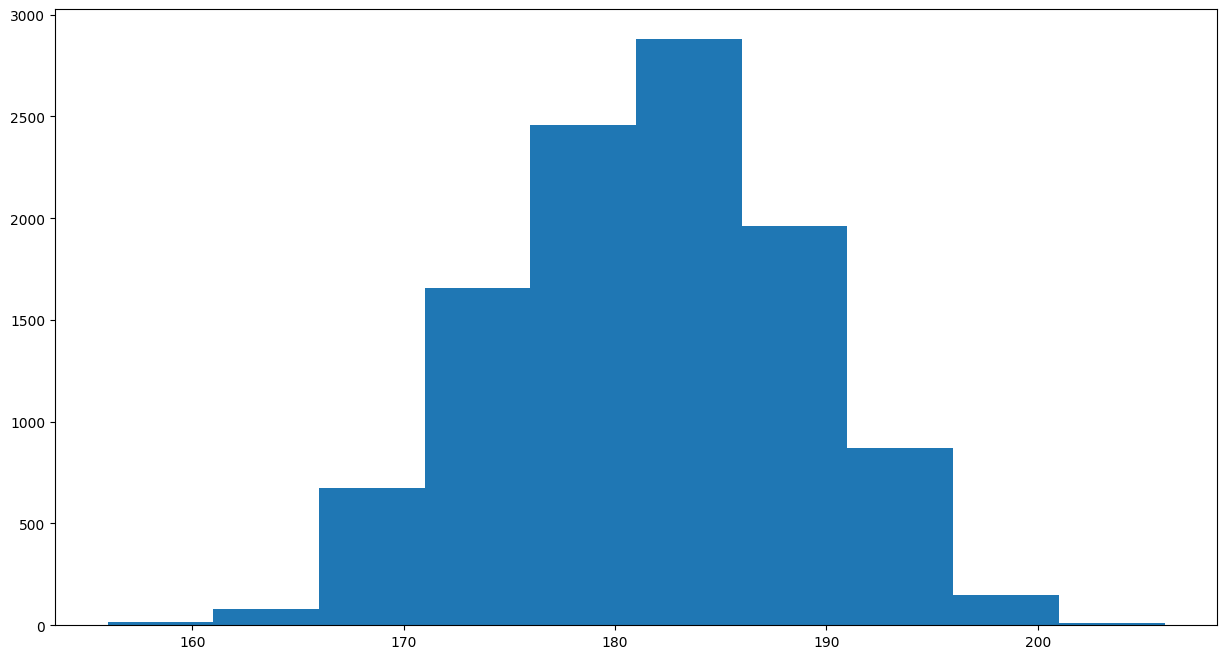

In [11]:
plt.figure(figsize=(15,8))
plt.hist(df['height'])

(array([ 105.,  635., 2157., 1590., 1599., 1994., 1101., 1068.,  326.,
         146.]),
 array([15. , 17.4, 19.8, 22.2, 24.6, 27. , 29.4, 31.8, 34.2, 36.6, 39. ]),
 <BarContainer object of 10 artists>)

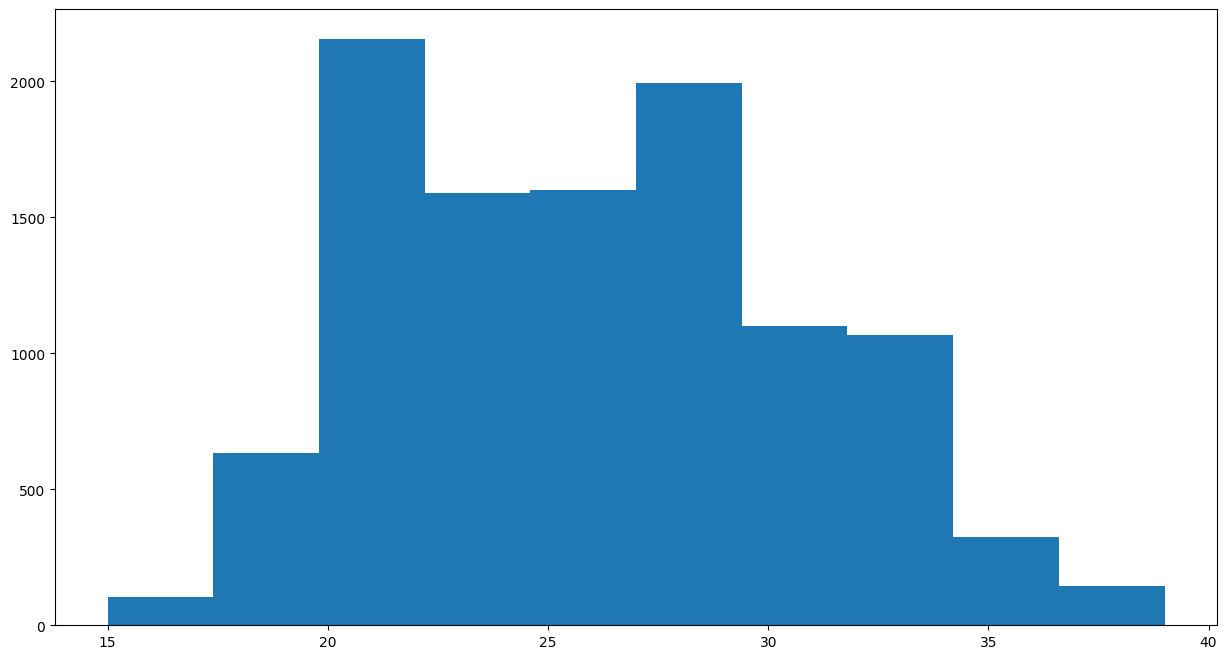

In [12]:
plt.figure(figsize=(15,8))
plt.hist(df[df['age']<40]['age'])


In [13]:
df = df[df['age']<40]

In [14]:
df.shape

(10721, 29)

(array([2262., 1738.,  837.,  969., 1130., 1222., 1179.,  813.,  376.,
         161.]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <BarContainer object of 10 artists>)

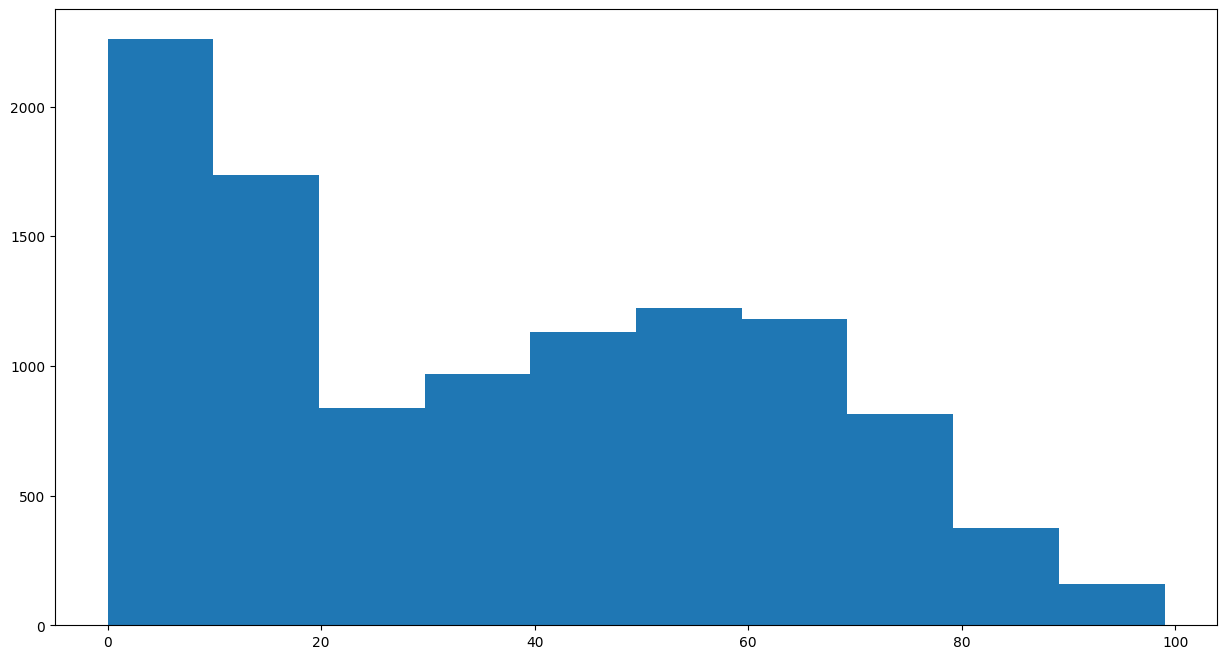

In [15]:
plt.figure(figsize=(15,8))
plt.hist(df[df['appearance']<100]["appearance"])

In [16]:
df = df[df["appearance"]<100]

In [17]:
df.shape

(10687, 29)

(array([5855., 1705.,  951.,  543.,  378.,  270.,  198.,  171.,  127.,
          93.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <BarContainer object of 10 artists>)

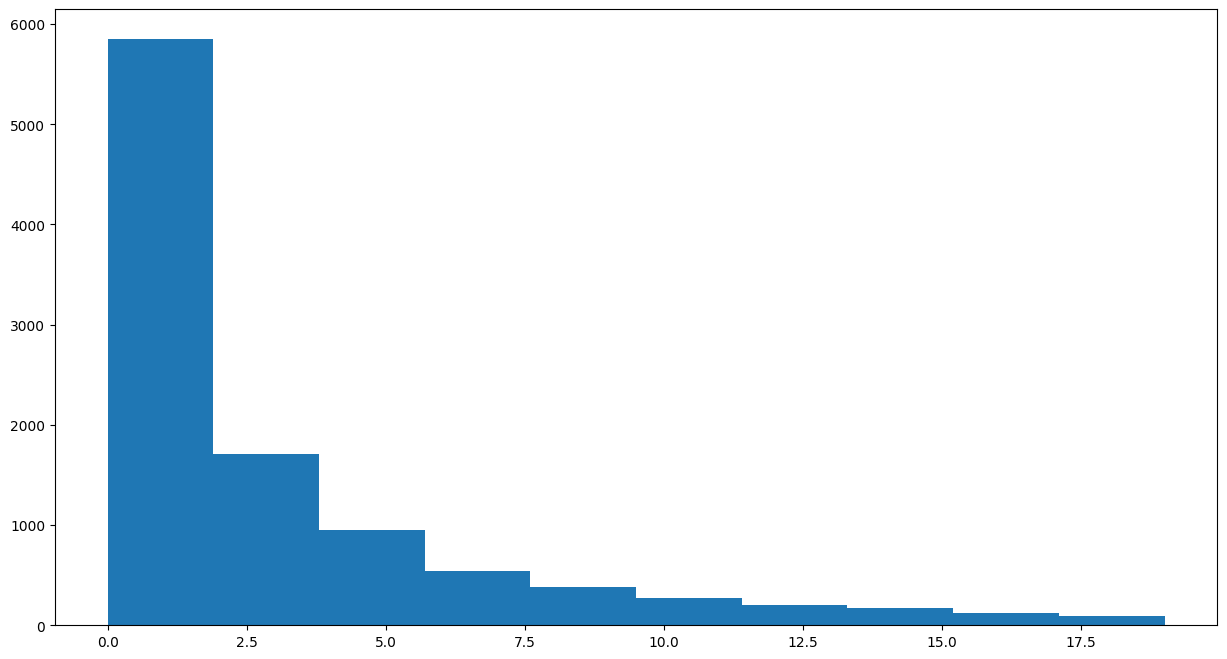

In [18]:
plt.figure(figsize=(15,8))
plt.hist(df[df['goals']<20]["goals"])

In [19]:
df = df[df["goals"]<20]

In [20]:
df.shape

(10291, 29)

(array([6143., 1087.,  690.,  552.,  392.,  281.,  273.,  196.,  154.,
         208.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

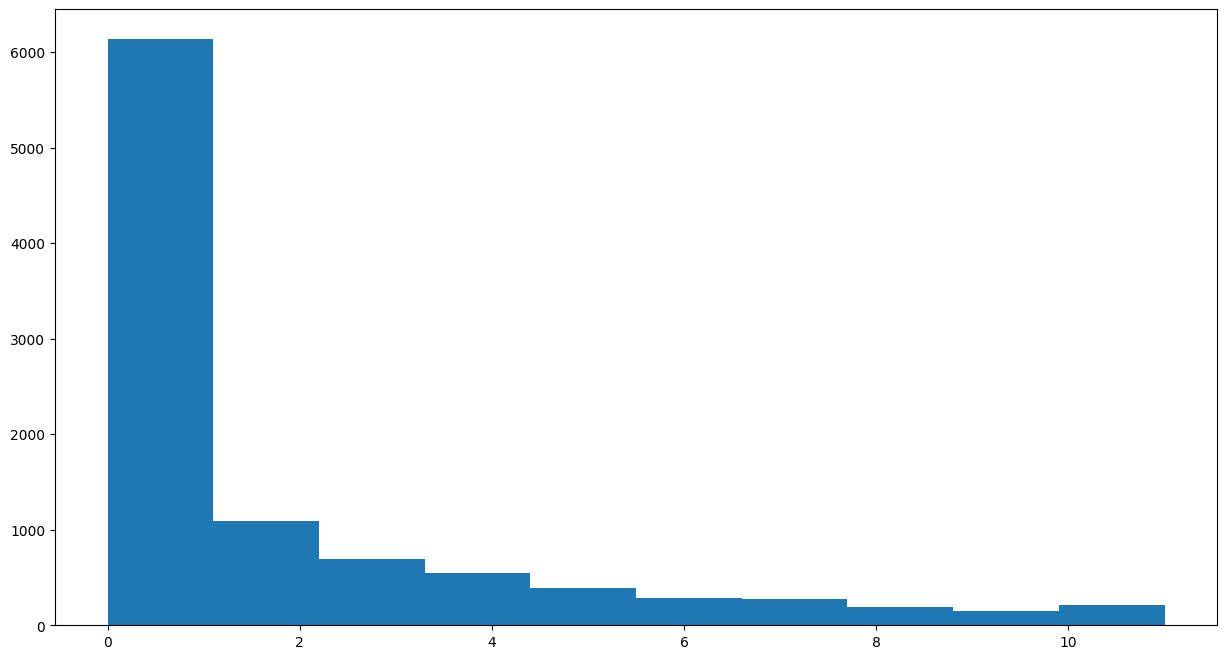

In [21]:
plt.figure(figsize=(15,8))
plt.hist(df[df['assists']<12]["assists"])

In [22]:
df = df[df['assists']<12]

In [23]:
df.shape

(9976, 29)

(array([3564., 1868., 1307.,  955.,  751.,  530.,  389.,  254.,  148.,
         126.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

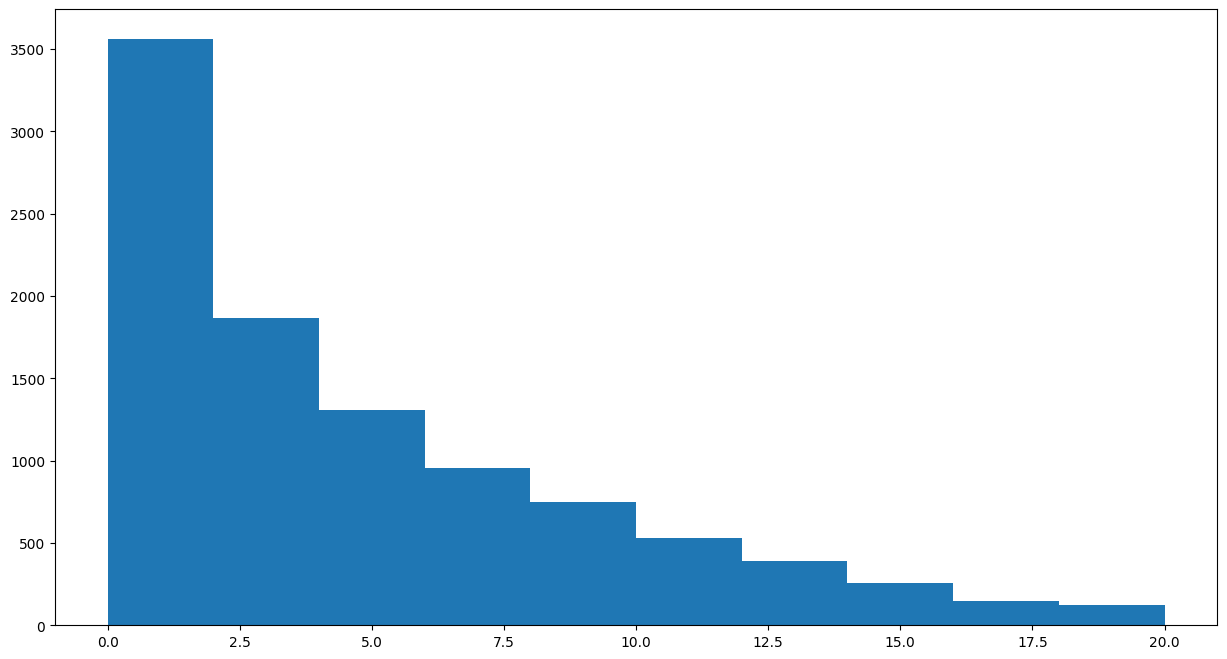

In [24]:
plt.figure(figsize=(15,8))
plt.hist(df[df['yellow cards']<=20]["yellow cards"])

In [25]:
df = df[df['yellow cards']<=20]

In [26]:
df.shape

(9892, 29)

In [27]:
df['second yellow cards'].value_counts()

second yellow cards
0    8892
1     887
2     100
3      12
4       1
Name: count, dtype: int64

In [28]:
df = df[df["second yellow cards"]<3]

In [29]:
df['red cards'].value_counts()

red cards
0    8720
1    1007
2     137
3      12
4       3
Name: count, dtype: int64

In [30]:
df = df[df["red cards"]<3]

(array([4580., 2069., 1098.,  643.,    0.,  391.,  272.,  173.,  166.,
          96.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

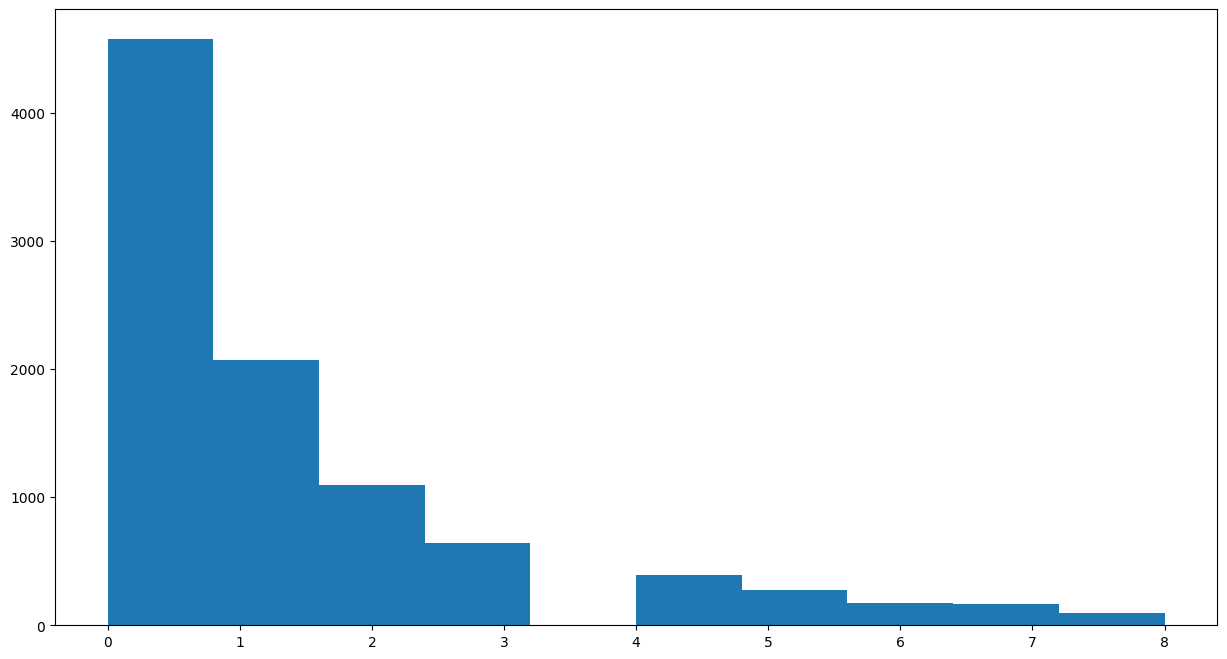

In [31]:
plt.figure(figsize=(15,8))
plt.hist(df[df["award"]<9]["award"])

In [32]:
df = df[df['award']<9]

(array([5758., 1127.,  708.,  652.,  392.,  268.,  168.,  132.,   82.,
          75.]),
 array([  0. ,  69.7, 139.4, 209.1, 278.8, 348.5, 418.2, 487.9, 557.6,
        627.3, 697. ]),
 <BarContainer object of 10 artists>)

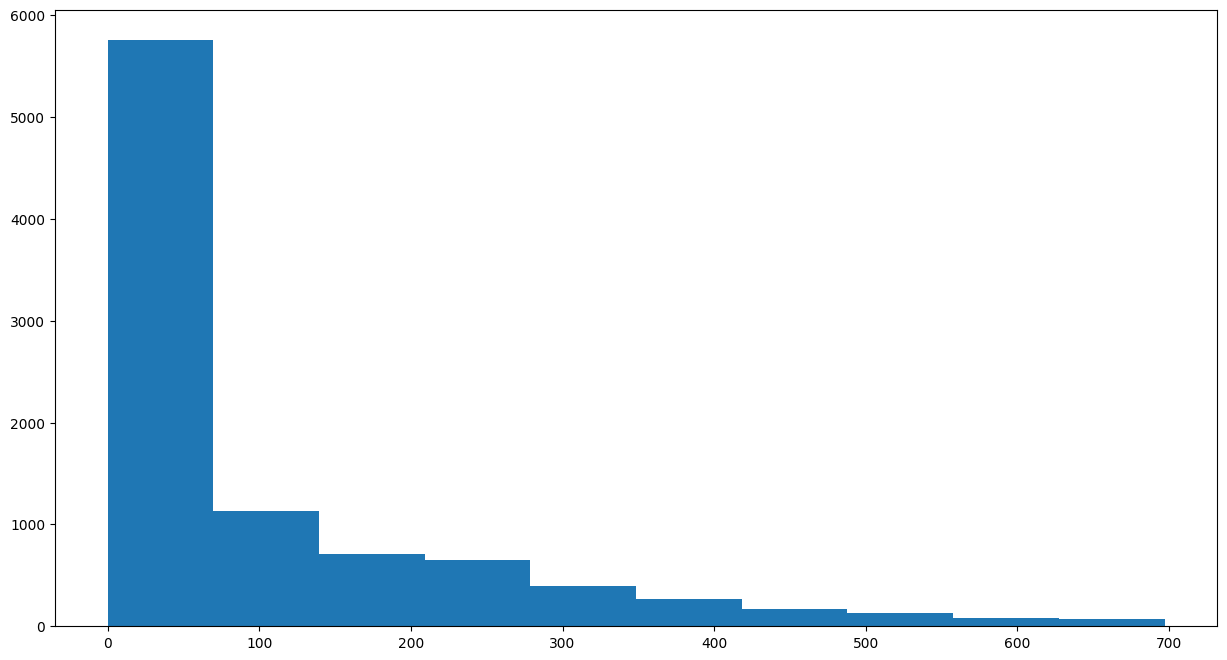

In [33]:
plt.figure(figsize=(15,8))
plt.hist(df[df["days_injured"]<=700]["days_injured"])

In [34]:
df = df[df["days_injured"]<=700]

(array([5304., 1041.,  749.,  544.,  425.,  347.,  275.,  219.,  156.,
          94.]),
 array([ 0. ,  6.9, 13.8, 20.7, 27.6, 34.5, 41.4, 48.3, 55.2, 62.1, 69. ]),
 <BarContainer object of 10 artists>)

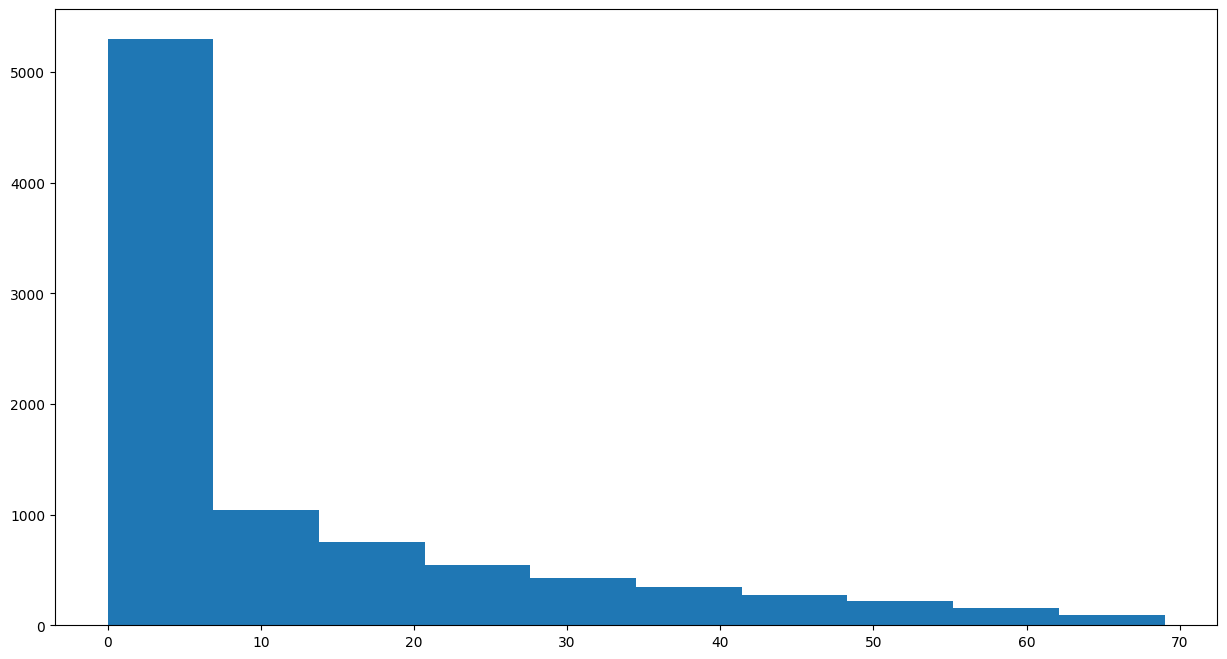

In [35]:
plt.figure(figsize=(15,8))
plt.hist(df[df['games_injured']<70]["games_injured"])

In [36]:
df = df[df['games_injured']<70]

(array([2836., 1536., 1044., 1060.,  862.,  760.,  536.,  266.,  177.,
          64.]),
 array([   0. ,  793.2, 1586.4, 2379.6, 3172.8, 3966. , 4759.2, 5552.4,
        6345.6, 7138.8, 7932. ]),
 <BarContainer object of 10 artists>)

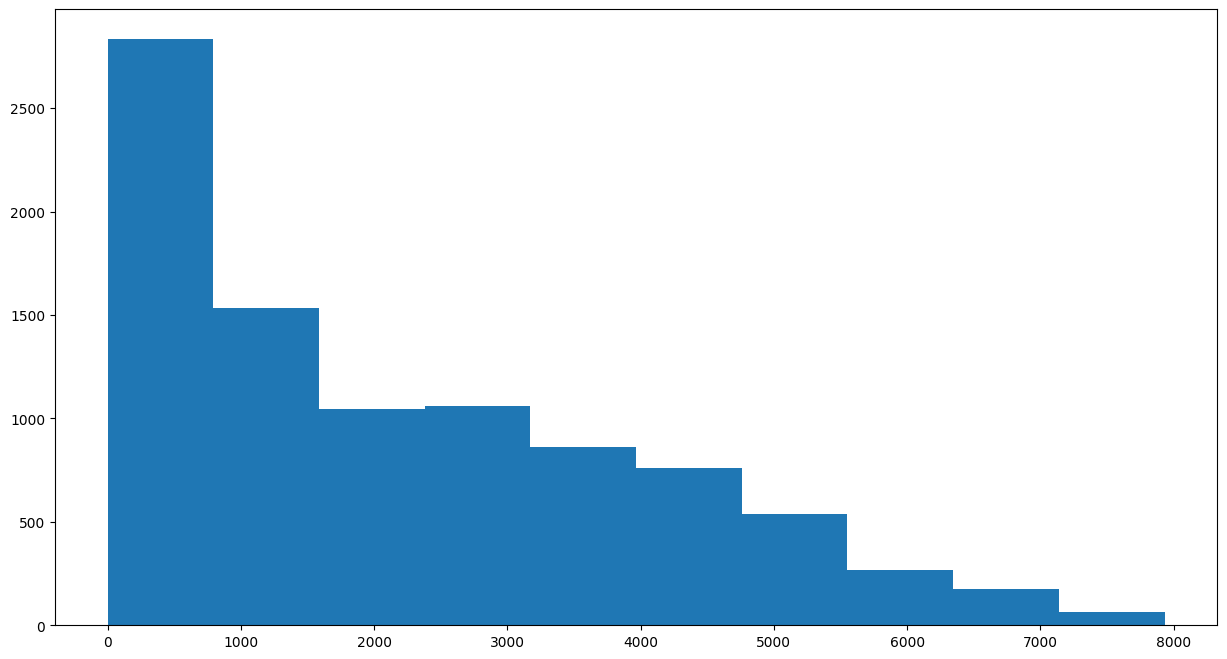

In [37]:
plt.figure(figsize=(15,8))
plt.hist(df[df["minutes played"]<8000]["minutes played"])

In [38]:
df = df[df["minutes played"]<8000]

In [39]:
df.columns

Index(['Unnamed: 0', 'team', 'name', 'position', 'height', 'age', 'appearance',
       'goals per 90', 'assists per 90', 'yellow cards per 90',
       'second yellow cards per 90', 'red cards per 90',
       'goals conceded per 90', 'clean sheets per 90', 'minutes played',
       'days_injured', 'games_injured', 'award', 'current_value',
       'highest_value', 'position_encoded', 'winger', 'goals', 'assists',
       'yellow cards', 'second yellow cards', 'red cards', 'goals conceded',
       'clean sheets'],
      dtype='object')

In [40]:
df = df.drop(['Unnamed: 0','goals per 90','assists per 90','yellow cards per 90','second yellow cards per 90',
         'red cards per 90','goals conceded per 90','clean sheets per 90'], axis=1)

In [41]:
df = df.drop(['position','name'],axis=1)

In [42]:
df.columns

Index(['team', 'height', 'age', 'appearance', 'minutes played', 'days_injured',
       'games_injured', 'award', 'current_value', 'highest_value',
       'position_encoded', 'winger', 'goals', 'assists', 'yellow cards',
       'second yellow cards', 'red cards', 'goals conceded', 'clean sheets'],
      dtype='object')

In [43]:
df.shape

(9141, 19)

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [44]:
df.head(2)

,team,height,age,appearance,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets
1,Manchester United,196.0,30,15,1304,510,58,1,1500000,22000000,1,0,0,0,1,0,0,18,3
5,Manchester United,194.0,30,68,4762,148,27,1,25000000,70000000,2,0,2,0,16,1,0,0,0


In [45]:
categorical_features

['team']

In [46]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [47]:
df.shape

(9141, 392)

In [48]:
df.head(2)

,height,age,appearance,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,...,team_West Ham United,team_Western Sydney Wanderers,team_Western United FC,team_Wigan Athletic,team_Wolfsberger AC,team_Wolverhampton Wanderers,team_Yokohama F. Marinos,team_Yokohama FC,team_Zenit St. Petersburg,team_Ümraniyespor
1,196.0,30,15,1304,510,58,1,1500000,22000000,1,...,False,False,False,False,False,False,False,False,False,False
5,194.0,30,68,4762,148,27,1,25000000,70000000,2,...,False,False,False,False,False,False,False,False,False,False


In [49]:
# Calculate the 35th and 75th percentiles of the price
p35 = df['current_value'].quantile(0.35)
p75 = df['current_value'].quantile(0.75)

# Function to categorize prices
def categorize_price(value):
    if value < p35:
        return 'Cheap_Value'
    elif value < p75:
        return 'Good_Value'
    else:
        return 'High_Value'

# Apply the function to create a new column
df['current_value_category'] = df['current_value'].apply(categorize_price)

df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['current_value_category'].value_counts())

current_value_category
Good_Value     3484
Cheap_Value    3134
High_Value     2523
Name: count, dtype: int64


In [50]:
p35, p75

(400000.0, 2000000.0)

In [51]:
encoder = LabelEncoder()
df['current_value_category'] = encoder.fit_transform(df['current_value_category']) 

#### 3. Feature selection

In [52]:
#sns.heatmap(df.corr(), annot=True);

In [53]:
correlation = df.corr()
print(correlation['current_value_category'].sort_values(ascending=False))

current_value_category       1.000000
highest_value                0.498643
appearance                   0.485456
minutes played               0.457293
yellow cards                 0.391094
                               ...   
team_Maritzburg United FC   -0.063717
team_Swallows FC            -0.064124
team_Richards Bay FC        -0.064679
team_Royal AM FC            -0.068353
team_Marumo Gallants FC     -0.069363
Name: current_value_category, Length: 392, dtype: float64


In [54]:
# Set the correlation threshold
threshold = 0.24  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['current_value_category']) > \
threshold]['current_value_category'].index
selected_features

Index(['appearance', 'minutes played', 'games_injured', 'award',
       'highest_value', 'goals', 'assists', 'yellow cards',
       'current_value_category'],
      dtype='object')

In [55]:
# selected_features = ['appearance', 'minutes played', 'current_value',
                    #  'highest_value', 'assists', 'yellow cards', 'goals']

In [56]:
df = df[selected_features]
df.head()

,appearance,minutes played,games_injured,award,highest_value,goals,assists,yellow cards,current_value_category
1,15,1304,58,1,22000000,0,0,1,1
5,68,4762,27,1,70000000,2,0,16,2
8,34,2758,13,0,2000000,0,0,4,2
10,89,7132,15,3,22000000,1,5,18,2
11,34,2686,28,1,12000000,0,1,10,2


#### 4. Prepare train and test data

In [57]:
# Prepare data
X = df


# sacle the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [58]:
X.shape

(9141, 9)

## Buliding the Model

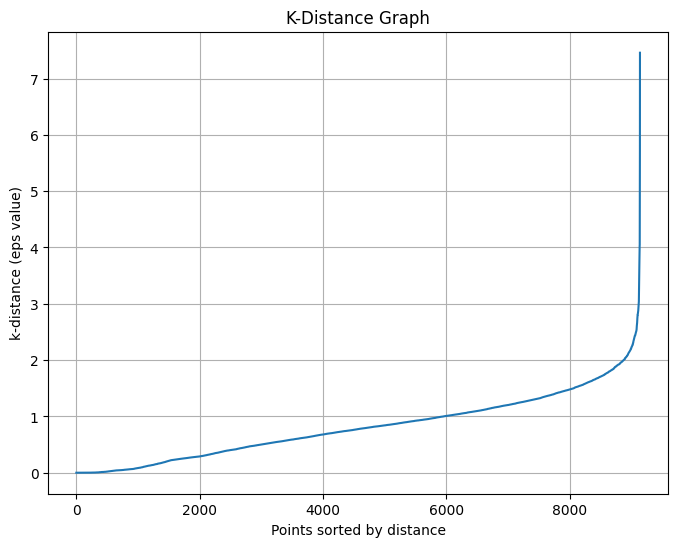

In [59]:
#model
# 2. Use NearestNeighbors to find the optimal eps
min_samples = 7
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)

# The distance to the furthest neighbor (min_samples-th nearest) for each point
k_dist = distances[:, min_samples-1]

# Sort distances
k_dist_sorted = np.sort(k_dist)

# 3. Plotting the k-distance graph
plt.figure(figsize=(8, 6))
plt.plot(k_dist_sorted)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance (eps value)')
plt.grid(True)
plt.show()

In [60]:
# 4. Apply DBSCAN with chosen eps and min_samples
# Typically, you choose eps at the "elbow" point in this plot, where the slope changes significantly
chosen_eps = 2  # This is an example; choose this value based on the plot
dbscan = DBSCAN(eps=chosen_eps, min_samples=min_samples)

## Train the Model

In [61]:
# Fit the model on the training data

clusters = dbscan.fit_predict(X_scaled)

In [62]:
pd.Series(clusters).value_counts()

 0    9056
-1      85
Name: count, dtype: int64

## Evaluating the Model 

In [64]:
# our benchmark model
silhouette_avg = silhouette_score(X, clusters)
silhouette_avg

0.8639298548181479

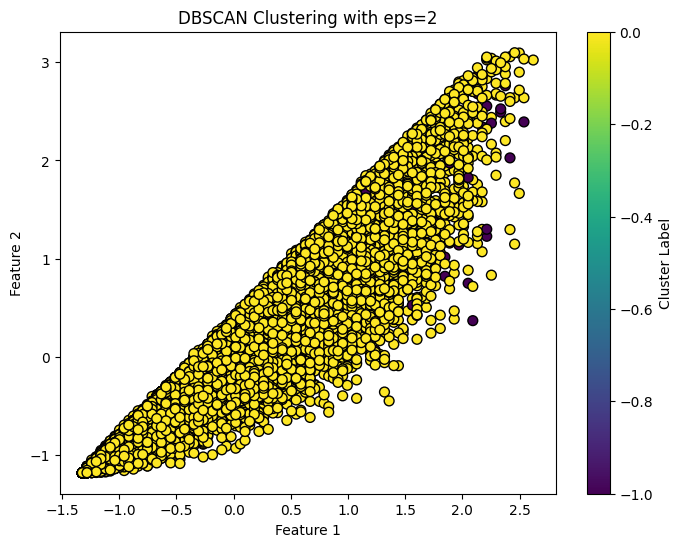

In [65]:
# Evaluate the model
# 5. Plot the clustering result
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=50, edgecolor='k')
plt.title(f'DBSCAN Clustering with eps={chosen_eps}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

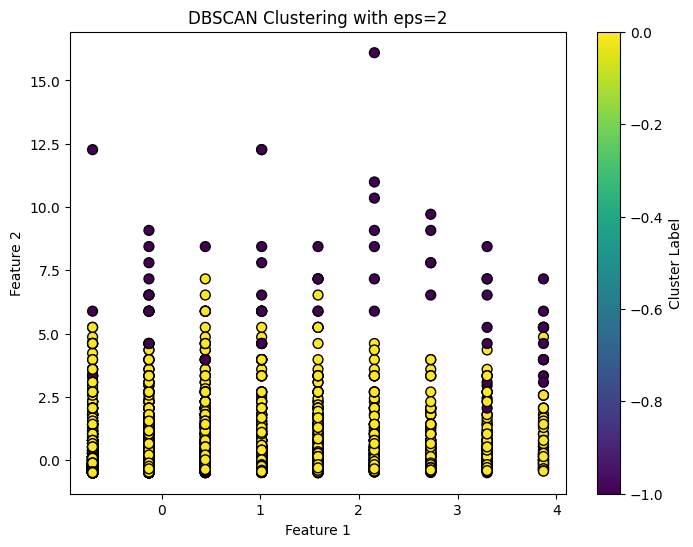

In [66]:
# 5. Plot the clustering result
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 3], X_scaled[:, 4], c=clusters, cmap='viridis', s=50, edgecolor='k')
plt.title(f'DBSCAN Clustering with eps={chosen_eps}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()